## Implementation

In [1]:
from pyscf import gto, scf, dft, fci, mcscf, ao2mo, tools
import numpy as np
np.set_printoptions(precision=8, suppress=True, linewidth=200)

In [2]:
# active is either a single list of active orbitals or a tuple with two lists
# the active orbital indices are 1-based
def fci_srdft(mf, nel_act, nmo_act, active, max_iter=100, threshold=1e-6, alpha=None, fci_solver=None, debug=False):

    # determine if the calculation is restricted or unrestricted
    if type(mf) == scf.rhf.RHF or type(mf) == dft.rks.RKS:
        nspins = 1
    elif type(mf) == scf.uhf.UHF or type(mf) == dft.uks.UKS:
        nspins = 2
    else:
        raise TypeError('unsupported mf object')

    # check format of active orbitals
    if type(active) == list:
        # then only one set of active orbitals
        assert(len(active) == nmo_act)
        active = [i -1 for i in active]
        if nspins == 2:
            active = (active, active)
    elif type(active) == tuple:
        assert(len(active) == 2)
        assert(len(active[0]) == nmo_act)
        assert(len(active[1]) == nmo_act)
        active = ([i-1 for i in active[0]],[i-1 for i in active[1]])
    else:
        raise TypeError('active orbitals must be a list or tuple')

    # we only support an even number of inactive electrons
    nel_ina = mf.mol.nelectron - nel_act
    assert(nel_ina % 2 == 0)
    spin = mf.mol.spin
    assert(nel_act % 2 == spin % 2)
    mult = mf.mol.multiplicity
    nel_fci = ((nel_act + mult - 1)//2, (nel_act - mult + 1)//2)

    # check if it is a range-separated calculation
    if hasattr(mf, 'omega'):
        omega = mf.omega
    else:
        omega = None

    # determine the inactive orbitals
    if nspins == 1:
        occupied = np.nonzero(mf.mo_occ)[0]
        inactive = [i for i in occupied if i not in active]
    elif nspins == 2:
        inactive = []
        for ispin in range(nspins):
            occupied = np.nonzero(mf.mo_occ[ispin])[0]
            inactive.append([i for i in occupied if i not in active[ispin]])
        # and make it a tuple
        inactive = tuple(inactive)
        assert(len(inactive[0]) == len(inactive[1]))

    # define inactive and active orbital spaces
    if nspins == 1:
        print('Inactive orbitals:', np.array(inactive)+1)
        print('Active orbitals:', np.array(active)+1)
    elif nspins == 2:
        print('Inactive orbitals alpha:', np.array(inactive[0])+1)
        print('Inactive orbitals beta: ', np.array(inactive[1])+1)
        print('Active orbitals alpha:', np.array(active[0])+1)
        print('Active orbitals beta: ', np.array(active[1])+1)

    # set occupation vectors for inactive and active MOs
    mo_occ_inactive = np.zeros_like(mf.mo_occ)
    if nspins == 1:
        mo_occ_inactive[inactive] = mf.mo_occ[inactive]
    else:
        mo_occ_inactive[0,inactive[0]] = mf.mo_occ[0,inactive[0]]
        mo_occ_inactive[1,inactive[1]] = mf.mo_occ[1,inactive[1]]

    print('Inactive occupations:\n', mo_occ_inactive)
    mo_occ_active = mf.mo_occ - mo_occ_inactive
    print('Active occupations:\n', mo_occ_active)

    # get active MO coefficients
    C = mf.mo_coeff
    if nspins == 1:
        C_A = C[:, active]
    elif nspins == 2:
        C_A = np.zeros((nspins, mf.mol.nao, nmo_act))
        C_A[0] = C[0,:,active[0]].transpose()
        C_A[1] = C[1,:,active[1]].transpose()
        # C_A = C[:,:,active]

    # inactive density matrix in AO basis
    D_I = mf.make_rdm1(C, mo_occ_inactive)

    # in the initial step, the active density matrix is equal to the
    # HF density matrix within the active subspace
    if nspins == 1:
        D_A_mo = np.zeros((nmo_act,nmo_act))
        for i in range(np.count_nonzero(mo_occ_active)):
            D_A_mo[i,i] = 2.0
    else:
        D_A_mo = np.zeros((nspins,nmo_act,nmo_act))
        for ispin in range(nspins):
            for i in range(np.count_nonzero(mo_occ_active[ispin])):
                D_A_mo[ispin,i,i] = 1.0

    # transform 1-RDM to AO basis
    D_A = np.zeros_like(D_I)
    if nspins == 1:
        D_A = np.einsum('pt,tu,qu->pq', C_A, D_A_mo, C_A)
        # D_A = mf.make_rdm1(C, mo_occ_active) # same as above
    else:
        for ispin in range(nspins):
            D_A[ispin] = np.einsum('pt,tu,qu->pq', C_A[ispin], D_A_mo[ispin], C_A[ispin])

    # get lr two-body MO integrals
    neri = nmo_act*(nmo_act+1)//2
    with mf.mol.with_range_coulomb(omega=omega):
        if nspins == 1:
            g_lr_mo = mf.mol.ao2mo(C_A)
        else:
            g_lr_mo = np.zeros((3, neri, neri))
            g_lr_mo[0] = mf.mol.ao2mo(C_A[0])
            g_lr_mo[1] = mf.mol.ao2mo((C_A[0], C_A[0], C_A[1], C_A[1]))
            g_lr_mo[2] = mf.mol.ao2mo(C_A[1])

    # get nuclear repulsion energy
    E_n = mf.mol.get_enuc()

    # create the FCI solver
    if fci_solver is None:
        if nspins == 1:
            fci_solver = fci.direct_spin1.FCI()
        else:
            fci_solver = fci.direct_uhf.FCI()
    # fci_solver = fci.addons.fix_spin_(fci_solver, ss=spin)

    # initialize history lists
    D_A_history = []
    E_history = []

    n_iter = 0
    D_A_history.append(D_A_mo)
    E_history.append(mf.e_tot)
    converged = False
    # start the iterative loop
    print(f'\nIter    <Ψ|S^2|Ψ>    Corr. energy      Total energy       Change')
    while n_iter < max_iter:
        n_iter += 1

        # update total density matrix
        D = D_I + D_A
        # get the KS potential and LR active components to subtract
        F_ks = mf.get_fock(dm=D)   # this is ks_mat

        J_A_lr, K_A_lr = mf.get_jk(dm=D_A, omega=omega)

        if nspins == 1:
            V_emb = F_ks - (J_A_lr - 0.5*K_A_lr)  # J_A_lr - 0.5*K_A_lr is ks_ref
        else:
            # sum alpha and beta Coulopmb contributions to each other
            J_A_lr[:] += J_A_lr[::-1]
            V_emb = (F_ks - (J_A_lr - K_A_lr))

        # transform embedding potential to active MO basis
        if nspins == 1:
            V_emb_mo = np.einsum('pt,pq,qu->tu', C_A, V_emb, C_A)
        else:
            V_emb_mo = np.zeros((2, nmo_act, nmo_act))
            for ispin in range(nspins):
                V_emb_mo[ispin] = np.einsum('pt,pq,qu->tu', C_A[ispin], V_emb[ispin], C_A[ispin])
                if debug:
                    print(f'V_emb_mo[{ispin}] =\n', V_emb_mo[ispin])

        # compute inactive energy
        E_I = mf.energy_tot(dm=D) - E_n
        if nspins == 1:
            E_I -=    np.einsum('pq,pq->', D_A, F_ks)
            E_I += .5*np.einsum('pq,pq->', D_A, (J_A_lr - 0.5*K_A_lr))
        else:
            for ispin in range(nspins):
                E_I -=    np.einsum('pq,pq->', D_A[ispin], F_ks[ispin])
                E_I += .5*np.einsum('pq,pq->', D_A[ispin], (J_A_lr[ispin] - K_A_lr[ispin]))

        # solve the FCI problem with the embedding potential and lr ERI
        E_A, CI_vec = fci_solver.kernel(h1e=V_emb_mo, eri=g_lr_mo, norb=nmo_act, nelec=nel_fci)
        if debug:
            print('\nInactive energy:', E_I + E_n)
            print('Active energy:', E_A)

        # new active density matrix
        if nspins == 1:
            D_A_mo = fci_solver.make_rdm1(CI_vec, norb=nmo_act, nelec=nel_fci)
            if alpha is not None:
                D_A_mo = (1-alpha)*D_A_mo + alpha*D_A_history[-1]
            # transform D_AO_mo to AO basis
            D_A = np.einsum('pt,tu,qu->pq', C_A, D_A_mo, C_A)

            # SS, Ms = fci.spin_square(CI_vec, norb=nmo_act, nelec=nel_fci)
            SS = 0
        else:
            # D_A_mo = fci_solver.make_rdm1s(CI_vec, norb=nmo_act, nelec=nel_fci)
            D_A_mo, d2_A_mo = fci_solver.make_rdm12s(CI_vec, norb=nmo_act, nelec=nel_fci)
            if alpha is not None:
                D_A_mo_a = (1-alpha)*D_A_mo[0] + alpha*D_A_history[-1][0]
                D_A_mo_b = (1-alpha)*D_A_mo[1] + alpha*D_A_history[-1][1]
                D_A_mo = (D_A_mo_a, D_A_mo_b)
            # transform D_AO_mo to AO basis
            for ispin in range(nspins):
                D_A[ispin] = np.einsum('pt,tu,qu->pq', C_A[ispin], D_A_mo[ispin], C_A[ispin])

            SS, Ms = fci.spin_op.spin_square_general(*D_A_mo, *d2_A_mo, C_A)

        # add to history
        D_A_history.append(D_A_mo)
        if debug:
            if nspins == 1:
                print('\nActive density matrix:\n', D_A_mo)
                print('Occupation numbers:\n', np.linalg.eigh(D_A_mo)[0], '\n')
            else:
                print('\nAlpha active density matrix:\n', D_A_mo[0])
                print('\nBeta active density matrix:\n', D_A_mo[1])
                occ_a,mos_a = np.linalg.eigh(D_A_mo[0])
                occ_b,mos_b = np.linalg.eigh(D_A_mo[1])
                print('\nAlpha active orbitals:\n', mos_a[:,0])
                print('\nAlpha active orbitals:\n', mos_a)
                print('\nBeta active orbitals:\n', mos_b)
                print('Occupation numbers:\n', np.asarray([occ_a, occ_b]), '\n')
                print('Total number of el:\n', np.sum(np.asarray([occ_a, occ_b]),axis=1), '\n')

        # check convergence
        E_history.append(E_I + E_A + E_n)
        delta_e = E_history[-1] - E_history[-2]
        E_corr = E_history[-1] - E_history[0]
        print(f'{n_iter:4d}    {SS:7.2f}     {E_corr:12.10f}    {E_history[-1]:12.10f}   {delta_e:+10.2e}')

        converged = np.abs(delta_e) < threshold
        if converged:
            print('Converged!')
            break

    if not converged:
        print('Not converged!')

    # return in any case the last density matrix and energy
    return E_history[-1], D_A_history[-1]


## Oxygen molecule

In [3]:
R = 2.0

mol = gto.M(
    atom = f'O 0.0 0.0 0.0; \
             O 0.0 0.0 {R};',
    basis='sto-3g',
    spin=2,
    verbose=3
)

omega = 0.5
mf_o2 = dft.UKS(mol)
mf_o2._numint.libxc = dft.xcfun
mf_o2.xc = f'ldaerf + lr_hf({omega})'
mf_o2.omega = omega

# mf = scf.UHF(mol)
# mf.kernel()

mf_o2.kernel()

# print orbitals
from pyscf import tools
tools.molden.dump_scf(mf_o2, 'o2.molden')

converged SCF energy = -146.96519355783  <S^2> = 2.0001745  2S+1 = 3.0001163


In [17]:
# 8 in 6 AS
active = [5,6,7,8,9,10]
nmo_act = len(active)
active = (active, active)
nel_act = 8

# 6 in 4 AS px and py MOs only
# good for R=1.5
# act_a = [5,6,8,9]
# act_b = [6,7,8,9]
# good for R=2.5
# act_a = [5,6,7,8]
# act_b = [6,7,9,10]
# active = (act_a, act_b)
# nmo_act = len(act_a)
# nel_act = 6

# 2 in 3 AS
# active = [8,9,10]
# nmo_act = len(active)
# active = (active, active)
# nel_act = 2

e,d = fci_srdft(mf_o2, nel_act, nmo_act, active, max_iter=100, threshold=1e-8, debug=False, alpha=0.0)

print('\nCorrelation energy:', e-mf_o2.e_tot)
print('\nAlpha active density matrix:\n', np.array2string(d[0], prefix=' '))
print('\nBeta active density matrix:\n', np.array2string(d[1], prefix=' '))

Inactive orbitals alpha: [1 2 3 4]
Inactive orbitals beta:  [1 2 3 4]
Active orbitals alpha: [ 5  6  7  8  9 10]
Active orbitals beta:  [ 5  6  7  8  9 10]
Inactive occupations:
 [[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]]
Active occupations:
 [[0. 0. 0. 0. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]]
(3, 21, 21)

Iter    <Ψ|S^2|Ψ>    Corr. energy      Total energy       Change
   1       2.12     -0.1098855387    -147.0750801407    -1.10e-01
   2       2.12     -0.1097743604    -147.0749689624    +1.11e-04
   3       2.12     -0.1097743451    -147.0749689471    +1.53e-08
   4       2.12     -0.1097743451    -147.0749689471    +2.22e-12
Converged!

Correlation energy: -0.10977434511320894

Alpha active density matrix:
 [[ 0.99999405 -0.         -0.         -0.         -0.         -0.        ]
  [-0.          0.99999405  0.         -0.          0.         -0.        ]
  [-0.          0.          0.99999652  0.          0.          0.        ]
  [-0.       

In [21]:
energies = []
densities = []
omegas = [100]

# 0.01 and 0.1 no good
# 0.2 good
# 1.1 good
# 10 and above good

for omega in omegas:
    mf_o2 = dft.UKS(mol)
    mf_o2._numint.libxc = dft.xcfun
    mf_o2.xc = f'ldaerf + lr_hf({omega})'
    mf_o2.omega = omega
    mf_o2.kernel()

    tools.molden.dump_scf(mf_o2, 'o2.molden')

    e,d = fci_srdft(mf_o2, nel_act, nmo_act, active, max_iter=40, threshold=1e-8, debug=True)
    energies.append(e)
    densities.append(d)

# print('\nCorrelation energy:', e-mf.e_tot)
# print('\nAlpha active density matrix:\n', np.array2string(d[0], prefix=' '))
# print('\nBeta active density matrix:\n', np.array2string(d[1], prefix=' '))


converged SCF energy = -147.033401008103  <S^2> = 2.0001411  2S+1 = 3.000094
Inactive orbitals alpha: [1 2 3 4]
Inactive orbitals beta:  [1 2 3 4]
Active orbitals alpha: [ 5  6  7  8  9 10]
Active orbitals beta:  [ 5  6  7  8  9 10]
Inactive occupations:
 [[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]]
Active occupations:
 [[0. 0. 0. 0. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]]

Iter    <Ψ|S^2|Ψ>    Corr. energy      Total energy       Change
V_emb_mo[0] =
 [[-3.64879015 -0.         -0.00000038  0.00000004  0.          0.        ]
 [-0.         -3.64879015 -0.00000004 -0.00000038 -0.          0.        ]
 [-0.00000038 -0.00000004 -3.64517911 -0.         -0.          0.        ]
 [ 0.00000004 -0.00000038 -0.         -3.64517911 -0.          0.        ]
 [ 0.         -0.         -0.         -0.         -3.68866256  0.00000003]
 [ 0.          0.          0.          0.          0.00000003 -3.67332849]]
V_emb_mo[1] =
 [[-3.68915517  0.         -0.          0.0

In [6]:
C = mf_o2.mo_coeff
# act_a = [5,6,8,9]
# act_b = [6,7,8,9]
act_a = [7,8,9]
act_b = [7,8,9]
active = (act_a, act_b)
nmo_act = len(act_a)

C_A = np.zeros((2, mf_o2.mol.nao, nmo_act))
C_A[0] = C[0,:,active[0]].transpose()
C_A[1] = C[1,:,active[1]].transpose()

C_A[1,:,[0,1]] = C_A[1,:,[1,0]]

# print(C_A[0])
# print(C_A[1])
S = mf_o2.get_ovlp()
C = mf_o2.mo_coeff
print('alpha alpha\n', C_A[0].T @ S @ C_A[0])
print('beta beta\n', C_A[1].T @ S @ C_A[1])
print('alpha beta\n', C_A[0].T @ S @ C_A[1])
print('beta alpha\n', C_A[1].T @ S @ C_A[0])

assert(False)

neri = nmo_act*(nmo_act+1)//2
with mf_o2.mol.with_range_coulomb(omega=omega):
    g = mf_o2.mol.intor('int2e', aosym='s1')
        # g_lr_mo = np.zeros((3, neri, neri))
        # g_lr_mo[0] = mf_o2.mol.ao2mo(C_A[0])
        # g_lr_mo[1] = mf_o2.mol.ao2mo((C_A[0], C_A[1], C_A[1], C_A[0]))
        # g_lr_mo[2] = mf_o2.mol.ao2mo(C_A[1])

pqrw = np.einsum("pqrs,sw->pqrw", g   , C_A[0])
pqvw = np.einsum("pqrw,rv->pqvw", pqrw, C_A[0])
puvw = np.einsum("pqvw,qu->puvw", pqvw, C_A[1])
g_mo = np.einsum("puvw,pt->tuvw", puvw, C_A[1])

for i in range(nmo_act):
    for j in range(i,nmo_act):
        for k in range(nmo_act):
            for l in range(k,nmo_act):
                if np.abs(g_mo[i,j,k,l]) > 1e-6:
                    print(i+1, j+1, k+1, l+1, f'{g_mo[i,j,k,l]:12.6f}')

alpha alpha
 [[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]
beta beta
 [[ 1.  0. -0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]
alpha beta
 [[ 0.79769972 -0.         -0.60305485]
 [-0.          0.         -0.        ]
 [ 0.          0.99992996 -0.        ]]
beta alpha
 [[ 0.79769972 -0.          0.        ]
 [-0.          0.          0.99992996]
 [-0.60305485 -0.         -0.        ]]


AssertionError: 

In [35]:
Rn = [1.0,1.2,1.5,2.0,2.5,3.0]
E_O2 = [-147.5834799276,
        -147.8038828905,
        -147.7825107960,
        -147.6859905508,
        -147.6850512652,
        -147.6850874189]

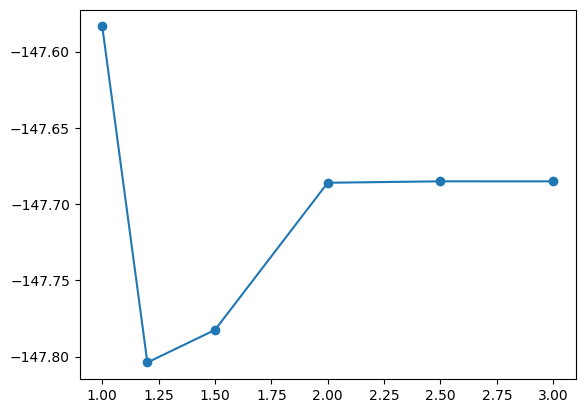

In [36]:
from matplotlib import pyplot as plt

plt.plot(Rn, E_O2, 'o-', label='O2')

## Nitrogen molecule

In [73]:
R = 1.8

mol = gto.M(
    atom = f'N 0.0 0.0 0.0; \
             N 0.0 0.0 {R};',
    basis='cc-pvtz',
    spin=0,
    verbose=4
)

omega = 0.4
mf = dft.RKS(mol)
mf._numint.libxc = dft.xcfun
mf.xc = f'ldaerf + lr_hf({omega})'
mf.omega = omega

mf.kernel()

System: uname_result(system='Linux', node='pauli', release='6.10.0-arch1-2', version='#1 SMP PREEMPT_DYNAMIC Mon, 22 Jul 2024 17:28:23 +0000', machine='x86_64')  Threads 16
Python 3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]
numpy 1.23.4  scipy 1.9.3
Date: Fri Jul 26 13:42:19 2024
PySCF version 2.1.1
PySCF path  /home/stefano/Miniconda/envs/qiskit/lib/python3.10/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 14
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 N      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr   0.0
[INPUT]  2 N      0.000000000000   0.000000000000   1.800000000000 AA    0.000000000000   0.000000000000   3.40150702

-108.32590583661003

In [66]:
active_6_6 = [5,6,7,8,9,10]
active_6_8 = [5,6,7,8,9,10,11,12]
active_6_9 = [5,6,7,8,9,10,11,12,13]
active_6_11 = [5,6,7,8,9,10,11,12,13,14,15]
active_6_12 = [5,6,7,8,9,10,11,12,13,14,15,16]
active_6_13 = [5,6,7,8,9,10,11,12,13,14,15,16,17]
active_6_14 = [5,6,7,8,9,10,11,12,13,14,15,16,17,18]

active  = active_6_6
nmo_act = len(active)
nel_act = 6

e,d = fci_srdft(mf, nel_act, nmo_act, active, threshold=1e-8)

print('\nCorrelation energy:', e-mf.e_tot)
print('\nActive density matrix:\n', np.array2string(d, prefix=' '))

Inactive orbitals: [1 2 3 4]
Active orbitals: [ 5  6  7  8  9 10]
Inactive occupations:
 [2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Active occupations:
 [0. 0. 0. 0. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Iter    <Ψ|S^2|Ψ>    Corr. energy      Total energy       Change
   1       0.00     -0.2017843605    -108.4317514560    -2.02e-01
   2       0.00     -0.2016529508    -108.4316200463    +1.31e-04
   3       0.00     -0.201

In [74]:
mf.mo_energy

array([-14.27317998, -14.27300349,  -0.98376256,  -0.81703674,  -0.49550153,  -0.44928379,  -0.44928379,  -0.10927772,  -0.10927772,   0.02940593,   0.50551577,   0.52576773,   0.52576773,
         0.56832612,   0.60579437,   0.60579437,   0.63210104,   0.93804906,   0.97470462,   0.97470462,   1.0452914 ,   1.04529184,   1.2051876 ,   1.20518813,   1.30491707,   1.51038188,
         1.51038188,   1.84066853,   2.73362424,   2.79415727,   2.79415727,   2.90006722,   2.90006722,   3.22829077,   3.696821  ,   3.696821  ,   3.73477282,   3.83208434,   3.83208559,
         3.92783851,   3.92783851,   3.95119051,   3.95119051,   4.04396499,   4.04396685,   4.24302439,   4.24302439,   4.40492484,   4.42147662,   4.4215016 ,   4.47624259,   4.47624259,
         4.52063717,   4.52065955,   4.76471824,   4.91902455,   4.91902455,   5.46127066,   5.5290276 ,   6.07437551])

In [53]:
list(range(5,11))
# transform a range into a list

[5, 6, 7, 8, 9, 10]

In [77]:
active_6_6 = [5,6,7,8,9,10]
active_6_14 = [5,6,7,8,9,10,11,12,13,14,15,16,17,18]


active  = list(range(5,10 +1))
nmo_act = len(active)
print(nmo_act)
nel_act = 6

scisolver = fci.SCI()
scisolver.max_cycle = 100
scisolver.conv_tol = 1e-8
scisolver.nroots = 1

e_rsdft, D_rsdft = fci_srdft(mf, nel_act, nmo_act, active, max_iter=20, threshold=1e-8, debug=False, alpha=0.0, fci_solver=scisolver)

print('\nCorrelation energy:', e_rsdft - mf.e_tot)
print('\nActive density matrix:\n', np.array2string(D_rsdft, prefix=' '))

# print('\nAlpha active density matrix:\n', np.array2string(d[0], prefix=' '))
# print('\nBeta active density matrix:\n', np.array2string(d[1], prefix=' '))

6
Inactive orbitals: [1 2 3 4]
Active orbitals: [ 5  6  7  8  9 10]
Inactive occupations:
 [2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Active occupations:
 [0. 0. 0. 0. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Iter    <Ψ|S^2|Ψ>    Corr. energy      Total energy       Change
   1       0.00     -0.0641352224    -108.3900410590    -6.41e-02
   2       0.00     -0.0640770642    -108.3899829008    +5.82e-05
   3       0.00     -0.0640770621    -108.3899828987    +2.14e-09
Converged!

Correlation energy: -0.06407706207565411

Active density matrix:
 [[ 1.96121283 -0.         -0.         -0.          0.          0.00000008]
  [-0.          1.89822178 -0.          0.00000058 -0.00000076 -0.        ]
  [-0.         -0.          1.8

In [7]:
umf = dft.UKS(mol)
umf._numint.libxc = dft.xcfun
umf.xc = f'ldaerf + lr_hf({omega})'
umf.omega = omega
umf.mol.spin = 0
umf.kernel()

converged SCF energy = -107.348216893765  <S^2> = -1.7763568e-15  2S+1 = 1


-107.34821689376453

In [8]:
active = [4,5,6,7,8,9]
n_el = 6

e,d = fci_srdft(umf, n_el, len(active), active, threshold=1e-8)

print('\nCorrelation energy:', e-umf.e_tot)
print('\nAlpha active density matrix:\n', np.array2string(d[0], prefix=' '))
print('\nBeta active density matrix:\n', np.array2string(d[1], prefix=' '))

Inactive orbitals: [[0, 1, 2, 3], [0, 1, 2, 3]]
Active orbitals: [4, 5, 6, 7, 8, 9]
Inactive occupations: [[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]]
Active occupations: [[0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]]

Iter    <Ψ|S^2|Ψ>    Corr. energy      Total energy       Change
   1       0.19     -0.2739760777    -107.6221929714    -2.74e-01
   2       0.19     -0.2739707235    -107.6221876172    +5.35e-06
   3       0.19     -0.2739707235    -107.6221876172    +9.95e-14
Converged!

Correlation energy: -0.27397072347551443

Alpha active density matrix:
 [[ 0.9727843   0.          0.          0.          0.         -0.        ]
  [ 0.          0.8735959  -0.          0.          0.         -0.        ]
  [ 0.         -0.          0.8735959  -0.          0.         -0.        ]
  [ 0.          0.         -0.          0.12737376 -0.         -0.        ]
  [ 0.          0.          0.         -0.          0.12737376 -0.        ]
  [-0.       

## Ethylene molecule

In [9]:
mol = gto.M(
    atom = 'C  0.0      0.0      0.66242; \
            C  0.0      0.0     -0.66242; \
            H -0.12018  0.91284  1.23164; \
            H  0.12018 -0.91284  1.23164; \
            H  0.12018  0.91284 -1.23164; \
            H -0.12018 -0.91284 -1.23164;',
    basis='sto-3g',
    spin=0,
    verbose=3
)

omega = 0.5
mf = dft.RKS(mol)
mf.chkfile = None
mf._numint.libxc = dft.xcfun
mf.xc = f'LDAERF + LR_HF({omega})'
mf.omega = omega
# mf = scf.RHF(mol)

mf.kernel()

converged SCF energy = -76.931780516158


-76.93178051615803

In [10]:
# active = [5,7,8,10,11]
active = [6,7,8,9]
n_el = 4

e,d = fci_srdft(mf, n_el, len(active), active)

print('\nCorrelation energy:', e-mf.e_tot)
print('\nActive density matrix:\n', np.array2string(d, prefix=' '))

Inactive orbitals: [0, 1, 2, 3, 4, 5]
Active orbitals: [6, 7, 8, 9]
Inactive occupations: [2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0.]
Active occupations: [0. 0. 0. 0. 0. 0. 2. 2. 0. 0. 0. 0. 0. 0.]

Iter    <Ψ|S^2|Ψ>    Corr. energy      Total energy       Change
   1       0.00     -0.0061210893    -76.9379016055    -6.12e-03
   2       0.00     -0.0061198200    -76.9379003362    +1.27e-06
   3       0.00     -0.0061198200    -76.9379003362    +1.17e-12
Converged!

Correlation energy: -0.006119820014163224

Active density matrix:
 [[ 1.99862239  0.0037951  -0.          0.        ]
  [ 0.0037951   1.98079283  0.          0.        ]
  [-0.          0.          0.01982072 -0.00178237]
  [ 0.          0.         -0.00178237  0.00076405]]
